## Demonstrating the SupplyComponent Class
This notebook demonstrates how to use the `SupplyComponent` class for scenario building in energy systems. We will showcase supply scenarios with:\
(a) Basic conversion technologies (fossil fuel plants)\
(b) Resource technologies (renewables with capacity factors)\
(c) Multi-mode technologies (CHP, fuel-switching)\
(d) Technologies with residual capacity and availability factors\
(e) Complete integrated supply scenario with all features

### 1. Import and Setup
First, import the class and set up a clean output directory for the demonstration.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

import numpy as np # for random number generation

### 2. Scenario Setup

In [2]:
import shutil
from pyoscomp.scenario.components.base import ScenarioComponent
from pyoscomp.scenario.components.supply import SupplyComponent

# Set up a clean demo output directory
DEMO_DIR = "demo_output/supply_component"
if os.path.exists(DEMO_DIR):
    shutil.rmtree(DEMO_DIR)
os.makedirs(DEMO_DIR, exist_ok=True)

In [3]:
# Common parameters for all scenarios
regions = ["North", "South", "East", "West"]
fuels = ["ELEC", "HEAT", "GAS_NAT", "COAL", "SOLAR_RESOURCE", "WIND_RESOURCE"]

### 3. Scenario 1: Basic Conversion Technologies
Demonstrates
- `add_technology()` - register technologies with operational life
- `set_conversion_technology()` - define simple fuel conversion (power plants)
- basic save/load workflow

In [4]:
# --- Scenario 1: Basic Conversion Technologies ---
scenario1_dir = os.path.join(DEMO_DIR, "scenario1")
os.makedirs(scenario1_dir, exist_ok=True)

# Copy time component prerequisite from existing scenario (see demo.time.ipynb)
ScenarioComponent.copy("demo_output/time_component/uniform", scenario1_dir, overwrite=True)

# Copy topology component prerequisite from existing scenario (see demo.topology.ipynb)
ScenarioComponent.copy("demo_output/topology_component/custom", scenario1_dir, overwrite=False)

scenario1 = SupplyComponent(scenario1_dir)
# Define basic conversion technologies for each region
for region in regions:
    
    # Coal Power Plant
    if np.random.rand() > 0.25:
        scenario1.add_technology(region, 'COAL_PP', operational_life=np.random.randint(5, 30))
        scenario1.set_conversion_technology( # set static efficiency across time
            region, 'COAL_PP', input_fuel='COAL', output_fuel='ELEC', efficiency=0.35
        )

    # Natural Gas Combined Cycle Gas Turbine
    if np.random.rand() > 0.25:
        scenario1.add_technology(region, 'GAS_CCGT', operational_life=np.random.randint(5, 30))
        scenario1.set_conversion_technology( # set time-varying efficiency
            region, 'GAS_CCGT', input_fuel='GAS_NAT', output_fuel='ELEC',
            efficiency={2020: 0.55, 2030: 0.58, 2040: 0.61}
        )

    # Gas Boiler for Heat
    scenario1.add_technology(region, 'GAS_BOILER', operational_life=np.random.randint(5, 30))
    scenario1.set_conversion_technology( # set different output fuel
        region, 'GAS_BOILER', input_fuel='GAS_NAT', output_fuel='HEAT', efficiency=0.9
    )

# Process and save the scenario
scenario1.process()
scenario1.save()

# Display the generated DataFrames
# Display results
print("=== Scenario 1: Basic Conversion Technologies ===")
print("\nOperational Life:")
print(scenario1.operational_life.head(10))
print("\nInput Activity Ratios:")
print(scenario1.input_activity_ratio.head(10))
print("\nOutput Activity Ratios:")
print(scenario1.output_activity_ratio.head(10))

=== Scenario 1: Basic Conversion Technologies ===

Operational Life:
  REGION  TECHNOLOGY  VALUE
0  North     COAL_PP     28
1  North    GAS_CCGT     25
2  North  GAS_BOILER     23
3  South    GAS_CCGT     28
4  South  GAS_BOILER     10
5   East     COAL_PP      9
6   East    GAS_CCGT     28
7   East  GAS_BOILER     16
8   West     COAL_PP     16
9   West  GAS_BOILER     15

Input Activity Ratios:
  REGION TECHNOLOGY     FUEL MODE_OF_OPERATION  YEAR     VALUE
0  North    COAL_PP     COAL             MODE1  2025  2.857143
1  North    COAL_PP     COAL             MODE1  2030  2.857143
2  North    COAL_PP     COAL             MODE1  2035  2.857143
3  North    COAL_PP     COAL             MODE1  2040  2.857143
4  North    COAL_PP     COAL             MODE1  2045  2.857143
5  North    COAL_PP     COAL             MODE1  2050  2.857143
6  North   GAS_CCGT  GAS_NAT             MODE1  2025  1.818182
7  North   GAS_CCGT  GAS_NAT             MODE1  2030  1.724138
8  North   GAS_CCGT  GAS_NAT    

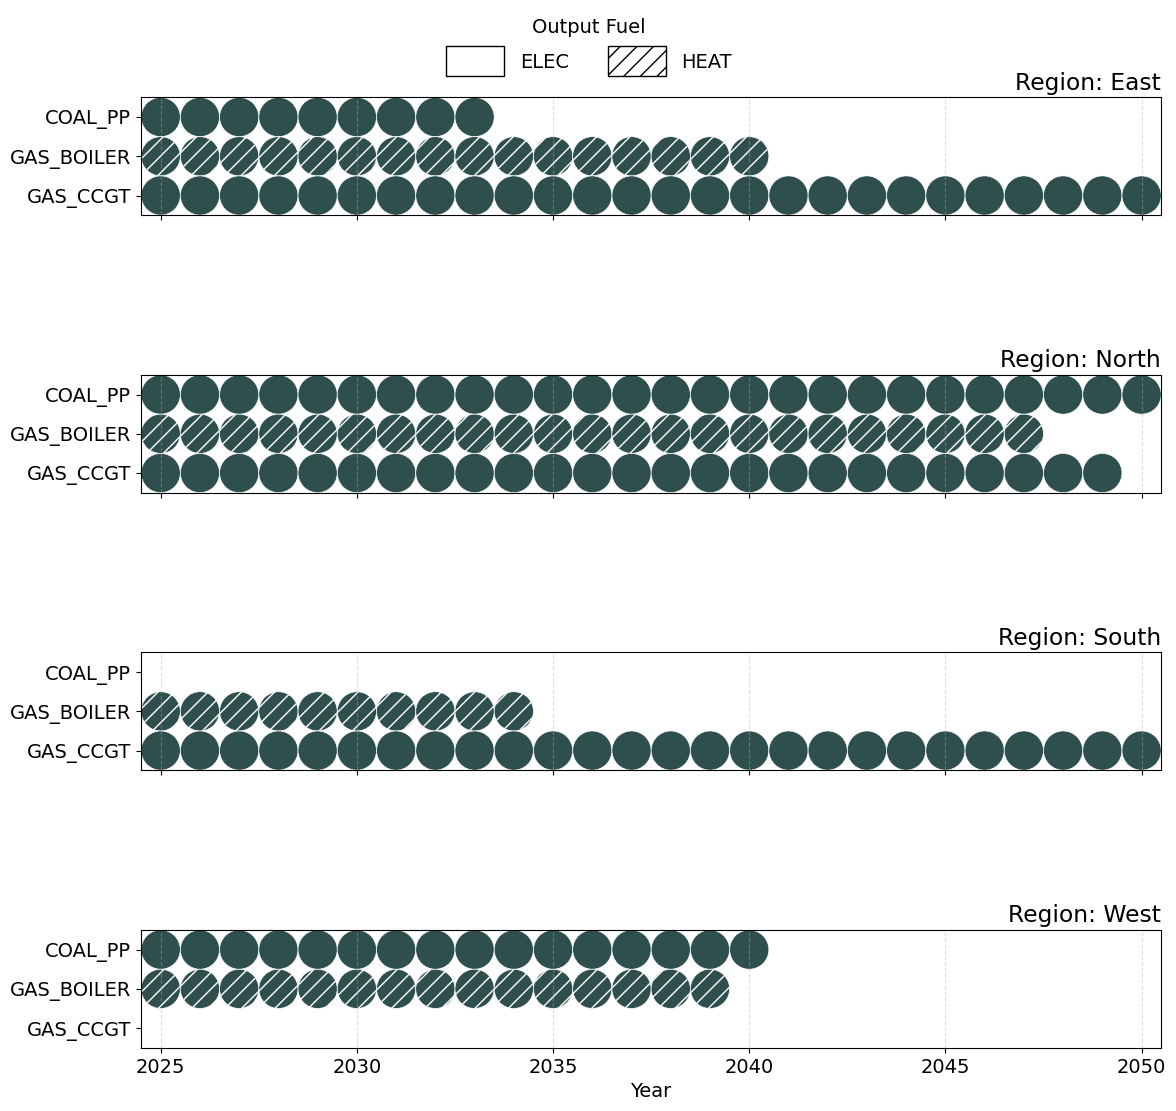

In [5]:
scenario1.visualize_technologies()

### 4. Scenario 2: Resource Technologies with Capacity Factors
Demonstrates
- `add_resource_technology()` - register technologies without input fuel
- `set_capacity_factor()` - timeslice-varying capacity factors
- `set_availability_factor()` - annual availability factoring in maintenance downtime

In [6]:
# --- Scenario 2: Resource Technologies with Capacity Factors ---
scenario2_dir = os.path.join(DEMO_DIR, "scenario2")
os.makedirs(scenario2_dir, exist_ok=True)

# Copy from scenario 1 as base
ScenarioComponent.copy(scenario1_dir, scenario2_dir, overwrite=True)

scenario2 = SupplyComponent(scenario2_dir)
scenario2.load()

for i, region in enumerate(regions):
    # Onshore Wind
    if np.random.rand() < 0.25:
        scenario2.add_technology(region, 'WIND_ONSHORE', operational_life=20) # register technology
        scenario2.set_resource_technology(region, 'WIND_ONSHORE', output_fuel='ELEC') # set as resource technology
        scenario2.set_capacity_factor( # set capacity factor profile using season_factor
            region, 'WIND_ONSHORE', season_factor = {'Winter': 0.45, 'Summer': 0.25}
        )
        scenario2.set_availability_factor( # set availability factor
            region, 'WIND_ONSHORE', availability=0.95
        )

    # Solar Photovoltaics
    if np.random.rand() < 0.25:
        scenario2.add_technology(region, 'SOLAR_PV', operational_life=25) # register technology
        scenario2.set_resource_technology(region, 'SOLAR_PV', output_fuel='ELEC') # set as resource technology
        scenario2.set_capacity_factor( # set capacity factor profile using time_factor
            region, 'SOLAR_PV', time_factor = {'Day': 0.3, 'Night': 0.0}
        )
        scenario2.set_availability_factor(region, 'SOLAR_PV', availability=0.92
        )

    if (region, 'COAL_PP') in scenario2.defined_tech:
        coal_availability = {2025: 0.9, 2030: 0.88, 2035: 0.82, 2040: 0.78, 2050: 0.75}
        scenario2.set_availability_factor(region, 'COAL_PP', availability=coal_availability)

# Process and save
scenario2.process()
scenario2.save()

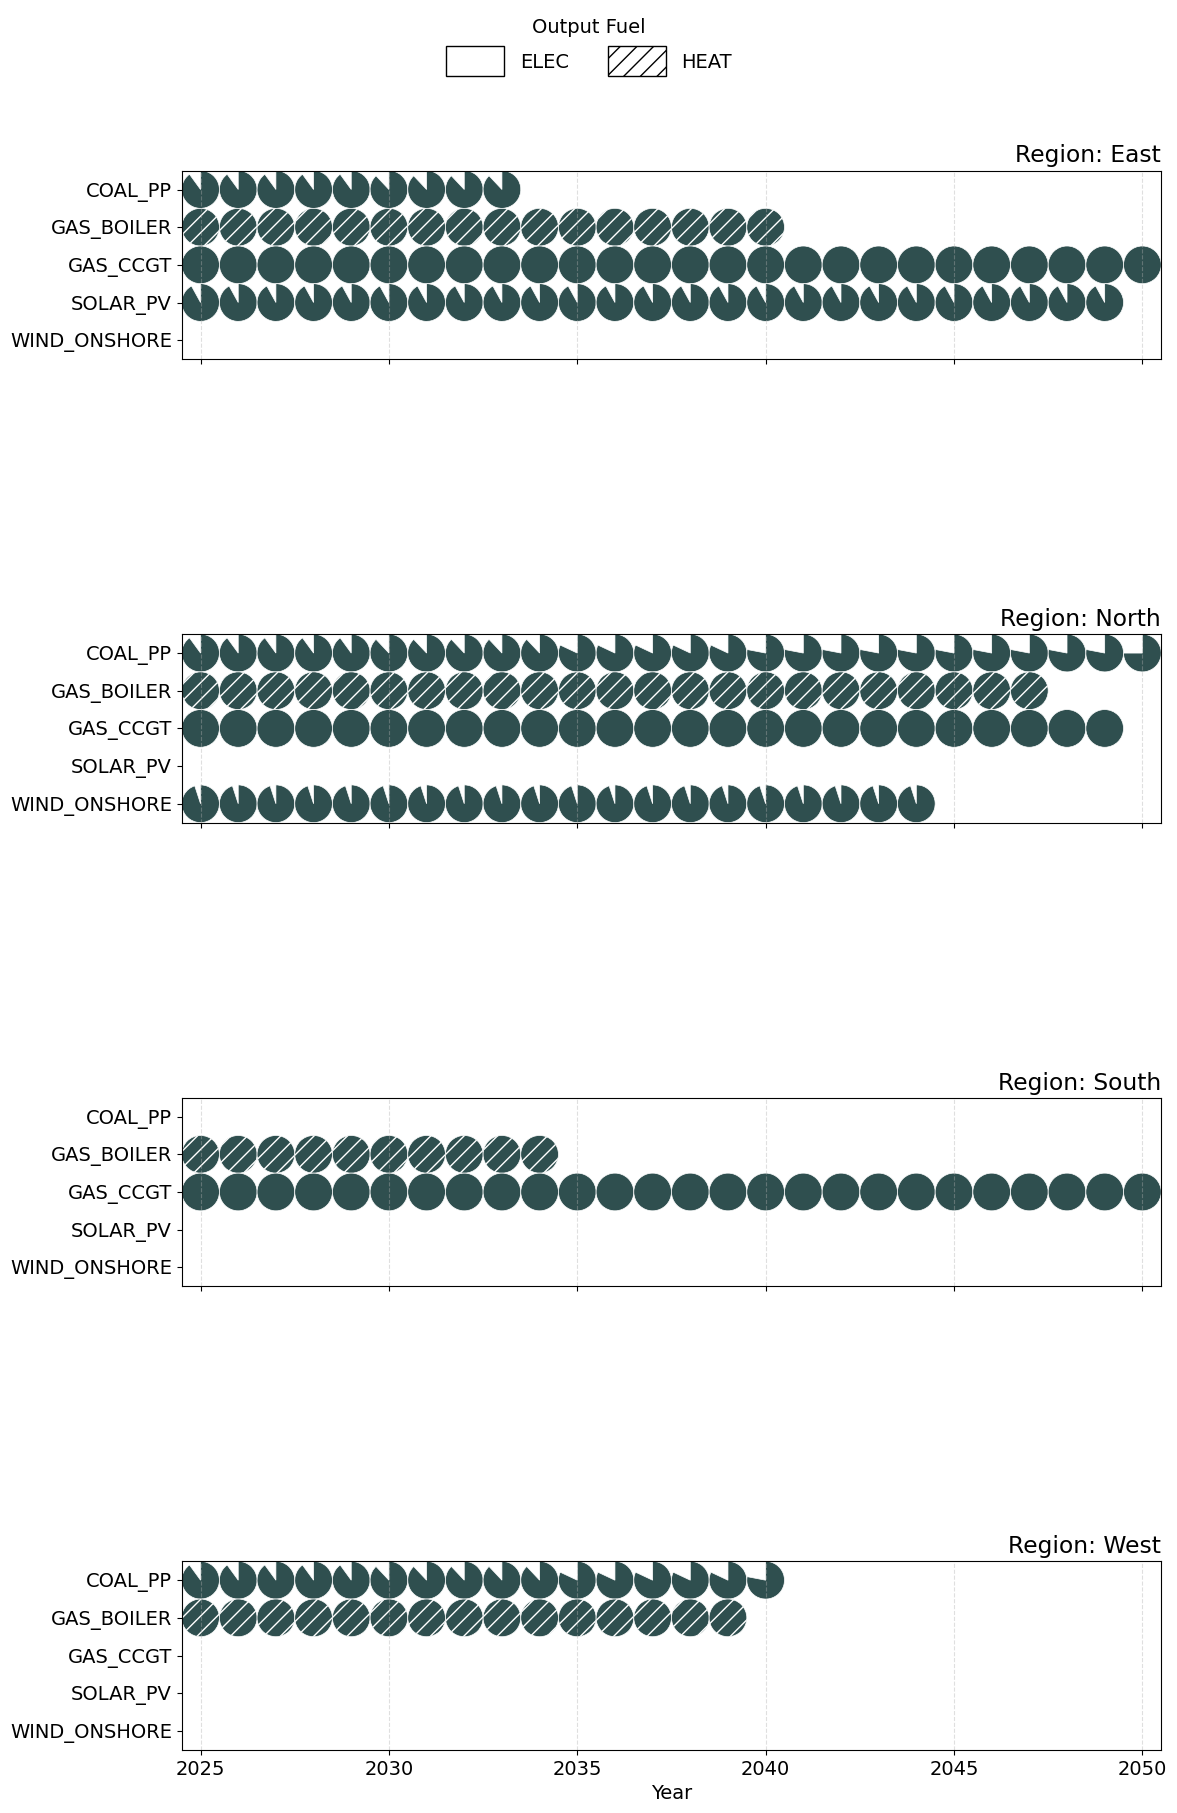

In [7]:
scenario2.visualize_technologies()